In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pandas as pd
from matplotlib import pyplot as plt

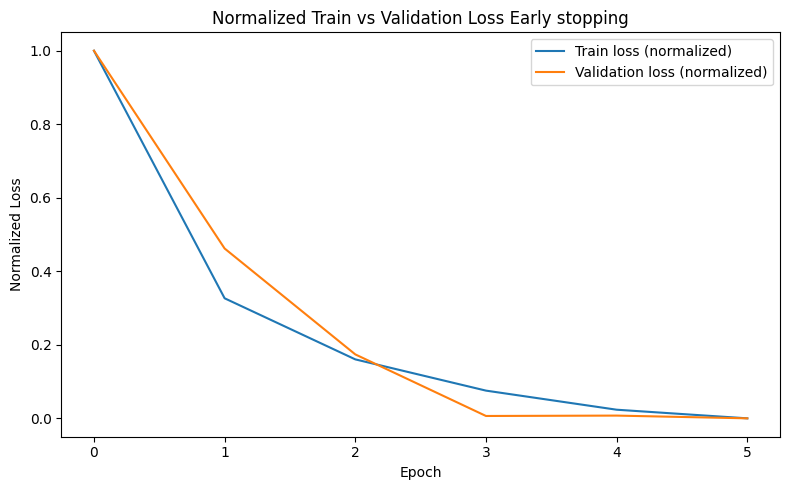

In [39]:
df = pd.read_csv('training_log.csv')
df = df[df['batch'] == 'avg']

df['val_loss'] = df['val_loss'].astype(float)
df['train_loss'] = df['train_loss'].astype(float)

# Min-max normalization
train_min = df['train_loss'].min()
train_max = df['train_loss'].max()
val_min = df['val_loss'].min()
val_max = df['val_loss'].max()

df['train_loss_norm'] = (df['train_loss'] - train_min) / (train_max - train_min)
df['val_loss_norm'] = (df['val_loss'] - val_min) / (val_max - val_min)

plt.figure(figsize=(8, 5))
plt.plot(df['train_loss_norm'].values, label="Train loss (normalized)", )
plt.plot(df['val_loss_norm'].values, label="Validation loss (normalized)")
plt.title("Normalized Train vs Validation Loss Early stopping")
plt.xlabel("Epoch")
plt.ylabel("Normalized Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [40]:
df

,timestamp,epoch,batch,train_loss,val_loss,train_loss_norm,val_loss_norm
595,2025-06-12 14:56:30,1,avg,0.008609,0.015075,1.000000,1.000000
1191,2025-06-12 15:05:32,2,avg,0.007259,0.013775,0.326567,0.461977
1787,2025-06-12 15:14:49,3,avg,0.006926,0.013079,0.160396,0.173917
2383,2025-06-12 15:27:15,4,avg,0.006755,0.012674,0.075400,0.006429
2979,2025-06-12 15:39:32,5,avg,0.006651,0.012677,0.023468,0.007465
3575,2025-06-12 15:51:42,6,avg,0.006604,0.012659,0.000000,0.000000


In [28]:
def evaluate_model(model, data_loader, scaler_y, device='cuda', return_preds=False):
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x_load, x_weather_hist, x_weather_fore, y in data_loader:
            x_load = x_load.to(device)
            x_weather_hist = x_weather_hist.to(device)
            x_weather_fore = x_weather_fore.to(device)

            preds = model(x_load, x_weather_hist, x_weather_fore)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())
    
    y_true = np.concatenate(all_targets, axis=0)
    y_pred = np.concatenate(all_preds, axis=0)

    return y_true, y_pred

    

In [53]:
from main import prepare_data

csv_path = 'mm79158.csv'
seq_len = 24
horizon = 12
train_loader, val_loader, test_loader, scaler = prepare_data(csv_path, seq_len, horizon, batch_size=32)
model = torch.load('best_model.pth')

Using device: cuda
Loading data...
Loaded and merged data by hourly aggregation.
Data split and scaled.
Train: 19061, Val: 2118, Test: 9077
Created 19025 sequences of length 24 with horizon 12.
Created 2082 sequences of length 24 with horizon 12.
Created 9041 sequences of length 24 with horizon 12.


C:\Users\janav\AppData\Local\Temp\ipykernel_16704\4056615054.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model.pth')


In [54]:
y_true, y_pred = evaluate_model(model, test_loader, scaler)

In [55]:
import numpy as np

def expand_with_zeros_and_inverse(arr, scaler, target_col_idx=0):
    n_samples, horizon = arr.shape
    n_features = scaler.n_features_in_

    # Create dummy input for scaler
    dummy_input = np.zeros((n_samples * horizon, n_features))
    dummy_input[:, target_col_idx] = arr.flatten()

    # Inverse transform
    dummy_output = scaler.inverse_transform(dummy_input)

    # Extract just the target column and reshape
    restored = dummy_output[:, target_col_idx].reshape(n_samples, horizon)
    return restored


In [56]:
y_true = expand_with_zeros_and_inverse(y_true, scaler)
y_pred = expand_with_zeros_and_inverse(y_pred, scaler)


📊 Final Flattened Evaluation:
MAE:  3.5639
MSE:  22.7872
MAPE: 85.64%


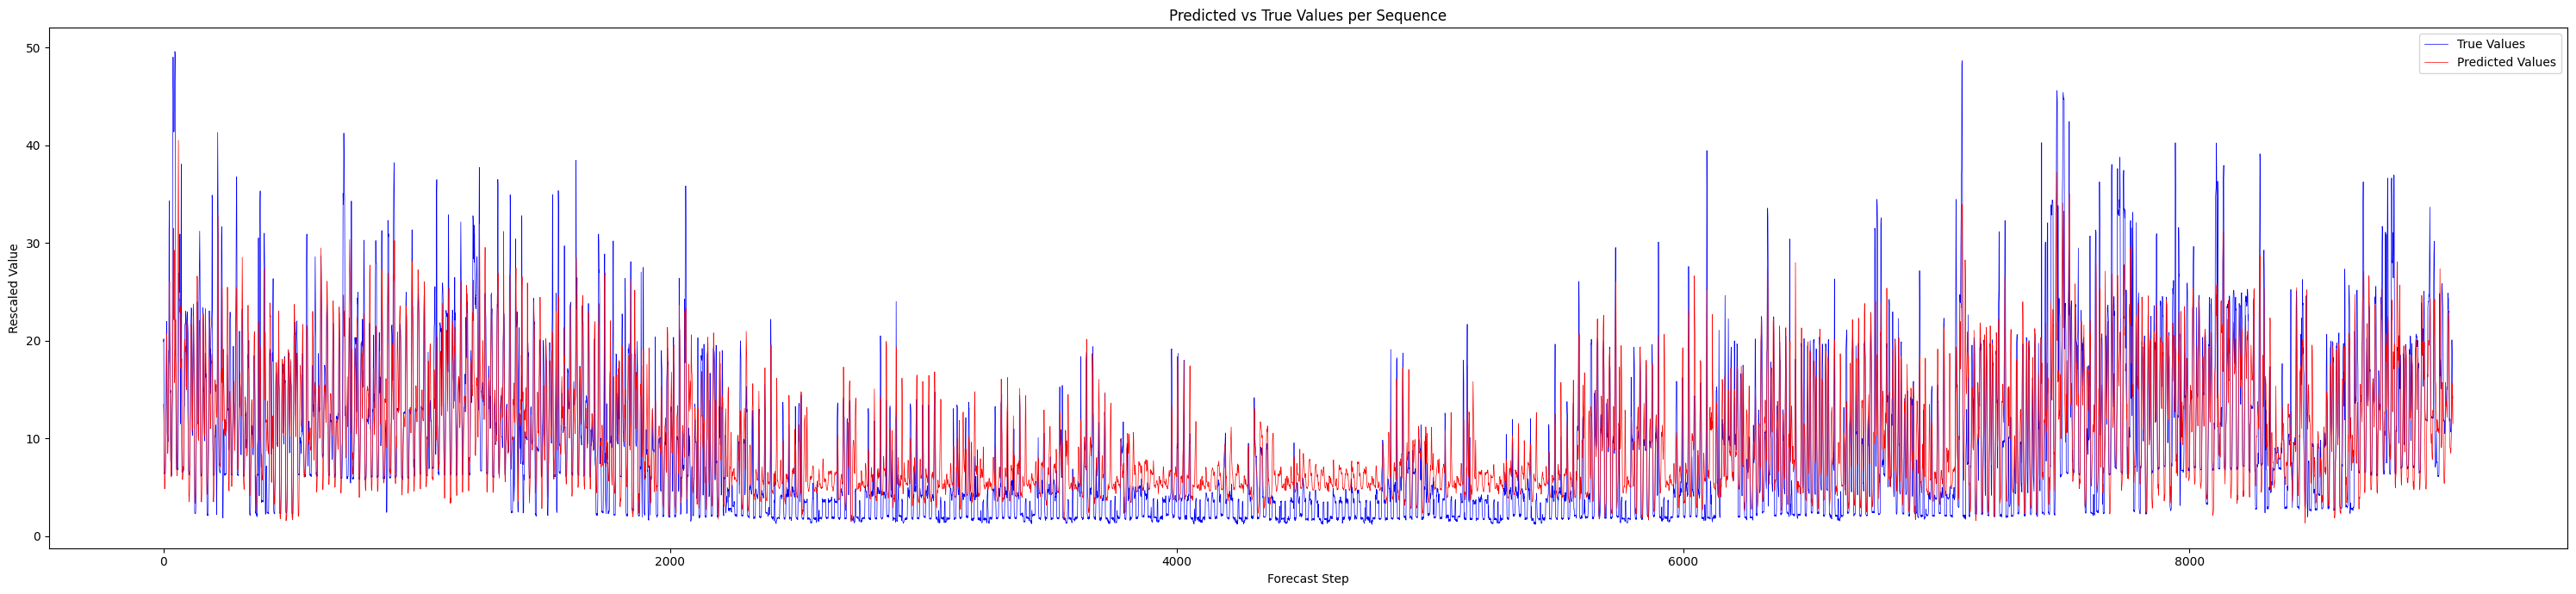

In [57]:
y_true_flat = y_true[:, 0]
y_pred_flat = y_pred[:, 0]

mae = mean_absolute_error(y_true_flat, y_pred_flat)
mse = mean_squared_error(y_true_flat, y_pred_flat)
mape = mean_absolute_percentage_error(y_true_flat, y_pred_flat)

print("\n📊 Final Flattened Evaluation:")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"MAPE: {mape:.2%}")

plt.figure(figsize=(30, 7))
plt.plot(y_true_flat, color='blue', linewidth=0.5, label='True Values')
plt.plot(y_pred_flat, color='red', linewidth=0.5, label='Predicted Values')
plt.title("Predicted vs True Values per Sequence")
plt.xlabel("Forecast Step")
plt.ylabel("Rescaled Value")
plt.legend()
plt.tight_layout()
plt.show()


In [58]:
def autoregressive_evaluation(model, val_loader, test_loader, horizon, device='cuda'):
    model.eval()
    model.to(device)

    # Get last sample from validation set as the initial context
    val_last = list(val_loader)[-1]
    x_load, x_weather_hist, x_weather_fore, _ = val_last

    x_load = x_load[0].unsqueeze(0).to(device)            # [1, 1, T]
    x_weather_hist = x_weather_hist[0].unsqueeze(0).to(device)
    x_weather_fore = x_weather_fore[0].unsqueeze(0).to(device)

    # Determine number of prediction steps to match test set size
    test_samples = len(test_loader.dataset)
    n_preds = test_samples * horizon
    full_preds = []

    steps = n_preds // horizon

    for _ in range(steps):
        with torch.no_grad():
            preds = model(x_load, x_weather_hist, x_weather_fore)  # [1, horizon]
        
        full_preds.append(preds.cpu().numpy())

        # Feed prediction back into input
        new_vals = preds.unsqueeze(1)  # [1, 1, horizon]
        x_load = torch.cat([x_load[:, :, horizon:], new_vals], dim=-1)

    y_pred = np.concatenate(full_preds, axis=0)
    return y_pred


In [59]:
y_auto = autoregressive_evaluation(model, val_loader, test_loader, horizon)
y_auto = expand_with_zeros_and_inverse(y_auto, scaler)

In [63]:
y_auto.min(), y_auto.max()

(2.043336794141531, 21.84299712348461)


📊 Final Flattened Evaluation:
MAE:  8.3277
MSE:  100.8742
MAPE: 239.30%


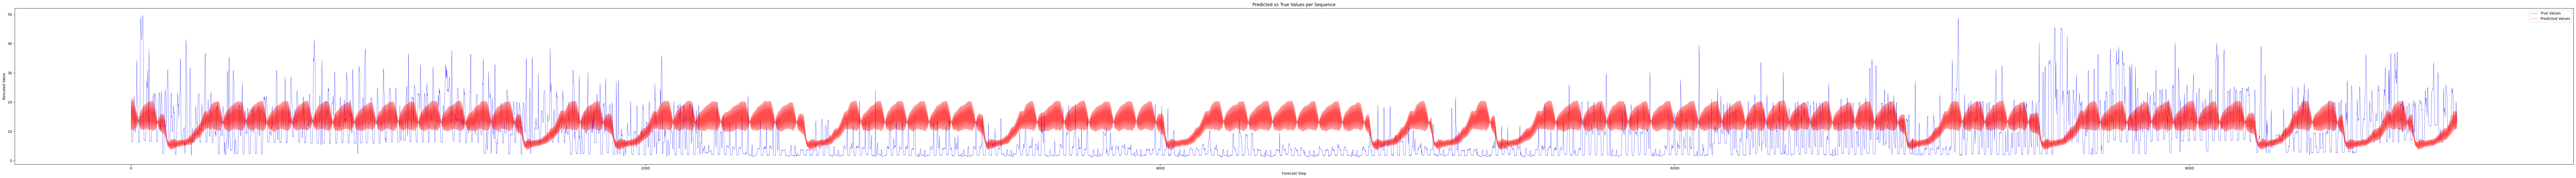

In [64]:
y_auto_flat = y_auto[:, 0]

mae = mean_absolute_error(y_true_flat, y_auto_flat)
mse = mean_squared_error(y_true_flat, y_auto_flat)
mape = mean_absolute_percentage_error(y_true_flat, y_auto_flat)

print("\n📊 Final Flattened Evaluation:")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"MAPE: {mape:.2%}")

plt.figure(figsize=(100, 7))
plt.plot(y_true_flat, color='blue', linewidth=0.5, label='True Values')
plt.plot(y_auto_flat, color='red', linewidth=0.5, label='Predicted Values')
plt.title("Predicted vs True Values per Sequence")
plt.xlabel("Forecast Step")
plt.ylabel("Rescaled Value")
plt.legend()
plt.tight_layout()
plt.show()
